The aim of this script is plotting weak meandering

In [40]:
#import neccesary modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy as sp
import os
import sys
import tecplot_io as tec 

In [41]:
#find the index  of grid points along azimuthal direction
#isinstance returns true if the object is of the specified type
def find_index(_z, _limits):
	_n = len(_z)
	_i_min = 0
	_i_max = _n - 1
	_limits2 = np.zeros(2)
	if isinstance(_limits, float):
		_limits2[0:2] = _limits
	else:
		_limits2 = _limits
		 			
	for i in range(_n):
		if _z[i]<_limits2[0] and i>_i_min :
			_i_min = i
		if _z[i]>_limits2[1] and i<_i_max :
			_i_max = i
	#print('zlimits='+str(_limits))
	#print('i_min='+str(_i_min)+', i_max='+str(_i_max))
	
	if isinstance(_limits, float):
		return _i_min
	else:
		return _i_min, _i_max


In [42]:
#plot blade line, but I don't know how it works
#plt.sca: visualize the scatter plot
#scatter: represents relationship between variables and uses dots to represent
#the relationship between them
#plt.plot: plot y versus x as lines and markers
# x: x-coordinate of the data points 
def plot_bladeline (_ax, _xc, _yc, _r):
	plt.sca(_ax)
	_n = len(_xc)
	for _i in range(_n):
		plt.plot([_xc[_i], _xc[_i]], [_yc[_i]-_r, _yc[_i]+_r], 'k-', linewidth=2)
	return

In [43]:
def get_coord_range (_loc, _D):
	_xc = _loc[0]
	_yc = _loc[1]
	#_xran = [_xc+0.2*_D, _xc+6.5*_D]
	#_yran = [_yc-2.0*_D, _yc+2.0*_D]
	_xran = [_xc+0.2*_D, _xc+6.0*_D]
	_yran = [_yc-2.0*_D, _yc+2.0*_D]
	return _xran, _yran

In [44]:
def get_index_range (_x, _y, _xran, _yran):
	#print ("range for x="+str(_x)+" is "+str(_xran))
	#print ("range for y="+str(_y)+" is "+str(_yran))
	_ixmin, _ixmax = find_index(_x, _xran)
	_iymin, _iymax = find_index(_y, _yran)
	_ixran = [_ixmin, _ixmax]
	_iyran = [_iymin, _iymax]
	
	return _ixran, _iyran

In [45]:
def collect_timeseries(_ixran, _y_ts, _u, _y2):	
	_iytemp = find_index(_y2, _y_ts)
	_u2 = _u[_ixran[0]:(_ixran[1]+1),_iytemp]
	return _u2

In [46]:
#np.argmin: returns the indices of the minimum values along an axis
#identify_wake_core(ixran[iturb,:], iyran[iturb,:], U2, x2, y2)
def identify_wake_core(_ixran, _iyran, _h, _x2, _y2, width=20, _method=1, _hw=6):
	_ix = []
	_iy = []
	_x = []
	_y = []
	print("ixran="+str(_ixran)+", iyran="+str(_iyran)+", iyran[0]="+str(_iyran[0]))
	print(_iyran[0]+_hw, _iyran[1]-_hw, _hw)
	
	#_tempwidth = (_iyran[1] - _iyran[0])/3
	_tempwidth = int((_iyran[1] - _iyran[0])/3)
	_tempstart = int(_iyran[0] + (_iyran[1] - _iyran[0])/2 - _tempwidth/2)
	print(_tempstart, _tempwidth)	
	_tempend = int(_tempstart + _tempwidth)
	
	#print("_iyran[0]="+str(_iyran[0])+", _iyran[1]="+str(_iyran[1]))
	#print("_iyran[0]="+str(_iyran[0])+", _iyran[1]="+str(_iyran[1]),"_tempwidth="+str(_tempwidth))
	#print("tempstart="+str(_tempstart)+", tempend="+str(_tempend))

	_utmp = np.zeros(_h.shape[1])
	print("_h.shape[1]="+str(_h.shape[1]))
	print("tempstart="+str(_tempstart)+", tempend="+str(_tempend))
	
	for _i in range(_ixran[0], _ixran[1]+1):
		#_ihmin = np.argmin(_h[_i, _iyran[0]:(_iyran[1]+1)])
		#print("ihmin="+str(_ihmin))
		#_itemp = _iyran[0] + _ihmin
		print('_i=',_i)
		if _method==1:
			# method 1: simply find the global minimum
			_ihmin = np.argmin(_h[_i, _tempstart:_tempend])
			#print("_j="+str(_j)+", _utmp[_j]="+str(_utmp[_j]))
			print("tempstart="+str(_tempstart)+", tempend="+str(_tempend))
		elif _method==2:
			# method 2: firstly get a band average value, then find the location of the minimum
			for _j in range(_iyran[0]+_hw, _iyran[1]-_hw):
				_utmp[_j] = np.average(_h[_i, (_j-_hw):(_j+_hw)])
				print("_j="+str(_j)+", _utmp[_j]="+str(_utmp[_j]))
				print("tempstart="+str(_tempstart)+", tempend="+str(_tempend))	
			_ihmin = np.argmin(_utmp[_tempstart:_tempend])
			
		## I'd like to set the hub as starting point of wake centerline
				
		
		## following code is to improve the continuity of search (only search for the next point in a range of last point.)
		## but it turns out to be easily limited to bottom or top edge of the search frame		
		_itemp = _tempstart + _ihmin
		_tempstart = _itemp - width/2
		
		_tempwidth = width
		
		_tempend = _itemp + width/2
		if _tempstart < (_iyran[0]+_hw):
			_tempstart = _iyran[0] + _hw	
		if _tempend > (_iyran[1]-_hw):
			_tempend = _iyran[1] - _hw
		
		_ix.append(_i)
		_iy.append(_itemp)
		_x.append(_x2[_i])
		_y.append(_y2[_itemp])
		print(str(_i)+" "+str(_itemp)+" "+str(_x2[_i])+" "+str(_y2[_itemp]))
	return _ix, _iy, _x, _y

In [47]:
def expand_domain(_in, _nepd, mode=0, shift=0):
	_nx = _in.shape[0]
	if len(_in.shape) == 2 :
		_ny = _in.shape[1]
	elif len(_in.shape) > 2 :
		print("Dimension should be 1 or 2.")
		_out = _in
		return _out
        
	_nx2 = _nx + _nepd
	if len(_in.shape) == 1 :
		# 1D case:
		_out = np.empty(_nx2)
		_out[:_nx] = _in[:_nx]
		_out[_nx:_nx2] =  _in[:_nepd]		
	elif len(_in.shape) == 2:
		# 2D case:
		_out = np.empty((_nx2, _ny))
		_out[:_nx, :] = _in[:_nx, :]
		
		if mode == 0:
			_out[_nx:_nx2, :] =  _in[:_nepd, :]	
		elif mode == 1:
			# interpolate/extrapolate
			for _i in range(_ny):				
				_fit = np.polyfit(np.arange(_nx), _in[:_nx, _i] ,1)
				_line = np.poly1d(_fit)
				_out[_nx:_nx2, _i] = _line(np.arange(_nx, _nx2))
				
		if shift == 1 :
			_out2 = _out[_nepd:_nx2, :]
			_out = _out2			
	
	return _out

In [48]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError('smooth only accepts 1 dimension arrays.')

    if x.size < window_len:
        raise ValueError('Input vector needs to be bigger than window size.')


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError('Window is on of flat, hanning, hamming, bartlett, blackman')


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    #print(len(y))
    #print(len(w))
    #return y
    
    _start = len(w)/2
    return y[(_start):(_start+len(x))]

In [49]:
sx = 7.0
sy = 7.0
hbar = 500.0
uinfty_o=11.5258407161
uhub_o=9.4546
zhub = 70.0
r = 40.0
D = 2.0*r
PEX = 0.00280499344071
XL = 2.0*np.pi/PEX

L0 = 1.0
U0 = 11.5258407161
T0 = L0/U0
dt = 0.342716489688*T0

ufric = 0.08442747 * U0

nx = 384
ny = 384
nz = 1
nvar = 6

icase = 0
tis = 10000
tie = 15000
tii = 100
y_ts = -2.0/3.0*r

yfftm3 = []
u_ts3 = []

In [50]:
#change working directory
path = 'd:\post\Refine'
os.chdir(path)

In [51]:
yfftm2 = []
u_ts2 = []

turbinefile = "Turbine.inp"
turbinedata = np.genfromtxt(turbinefile, skip_header=1)
turbineloc = turbinedata[:,3:5]
nturbine = len(turbineloc[:,0])
print(nturbine)
nepd = 384//8 - 4

16


d:\post\Refine\POST_U_2D2_0002\POST_U_2D2_0000010000_0002.DAT
(384, 384)
iturb = 0
xran[iturb,:] = [296. 760.]
yran[iturb,:] = [120. 440.]
xran[iturb,:] = [296. 760.]
yran[iturb,:] = [120. 440.]
ixran[iturb,:] = [ 5 86]
iyran[iturb,:] = [19 75]
ixran=[ 5 86], iyran=[19 75], iyran[0]=19
25 69 6
38 18
_h.shape[1]=384
tempstart=38, tempend=56
_i= 5
tempstart=38, tempend=56
5 47 291.66667 280.0
_i= 6


TypeError: slice indices must be integers or None or have an __index__ method

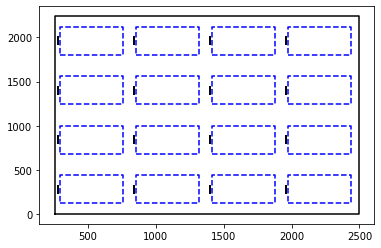

In [52]:
fig5, ax5 = plt.subplots()
xtmp1 = nepd*XL/nx
xtmp2 = XL + xtmp1
ax5.plot([xtmp1, xtmp2, xtmp2, xtmp1, xtmp1], [0, 0, XL, XL, 0], 'k-') # draw the domain boundary
for iturb in range(nturbine):
	xtmp, ytmp = get_coord_range(turbineloc[iturb,:], D)
	ax5.plot([xtmp[0], xtmp[1], xtmp[1], xtmp[0], xtmp[0]], [ytmp[0], ytmp[0], ytmp[1], ytmp[1], ytmp[0]], 'b--') # draw the search frame
plot_bladeline(ax5, turbineloc[:,0], turbineloc[:,1], r)

	# allmin 
allmins = []
for iturb in range(nturbine):
	allmins.append(list())


for it in range(tis, tie, tii):
	filename = path +"\POST_U_2D2_0002"+ "\POST_U"+"_2D2_{:010d}".format(it) + "_0002.DAT"
	print(filename)
	data0 = tec.tecplot_reader(filename, [nz, ny, nx, nvar], 2)
	data0 = data0.reshape([ny, nx, nvar])
	##  VARIABLES = X, Y, Z, U, V, W

	X = data0[:,:,0].reshape([ny,nx]).transpose()
	Y = data0[:,:,1].reshape([ny,nx]).transpose()
	U = data0[:,:,3].reshape([ny,nx]).transpose()

	#um = np.average(U)
	#print("um="+str(um))
	um=0.907800731501
	U1 = U / um
	x1 = X[:,0]
	y1 = Y[0,:]
		
	U2 = expand_domain(U1, nepd, shift=1)
	X2 = expand_domain(X, nepd, mode=1, shift=1)
	Y2 = expand_domain(Y, nepd, shift=1)
	x2 = X2[:,0]
	y2 = Y2[0,:]

	print(U2.shape)	
	#print(turbineloc)
	xran = np.zeros((nturbine,2))
	yran = np.zeros((nturbine,2))
	ixran = np.zeros((nturbine,2), dtype='int')
	iyran = np.zeros((nturbine,2), dtype='int')
	xwake = []
	ywake = []
	ywpo = [] # original location of velocity minima
	ywp = [] # spacial smoothed location of velocity minima
	yfft = []
	yfftm = []
	u_ts = []
		
	for iturb in range(nturbine):
		xran[iturb,:], yran[iturb,:] = get_coord_range(turbineloc[iturb,:], D)
		ixran[iturb,:], iyran[iturb,:] = get_index_range(x2, y2, xran[iturb,:], yran[iturb,:])
		#check
		print('iturb =',iturb)
		print('xran[iturb,:] =', xran[iturb,:])
		print('yran[iturb,:] =', yran[iturb,:])
		print('xran[iturb,:] =', xran[iturb,:])
		print('yran[iturb,:] =', yran[iturb,:])
		print('ixran[iturb,:] =', ixran[iturb,:])
		print('iyran[iturb,:] =', iyran[iturb,:])
			
		y2_ts = (yran[iturb,0] + yran[iturb,1])/2.0 + y_ts
		# u_ts_temp[wake_line_point_index] is velocity at a line along streamline, this line is parallel to rotor centerline with a distance of y_ts
		u_ts_temp = collect_timeseries(ixran[iturb,:], y2_ts, U2, y2)
		# u_ts[turbine_index][wake_line_point_index]
		u_ts.append(u_ts_temp)
			
		ixtemp, iytemp, xtemp, ytemp = identify_wake_core(ixran[iturb,:], iyran[iturb,:], U2, x2, y2)
		#print('iturb =',iturb)
		

In [ ]:
xtemp = np.array(xtemp)
		ytemp = np.array(ytemp)
		xwake.append(xtemp)
		ywake.append(ytemp)
		print("before smooth: len="+str(len(ytemp)))
		print(ytemp)
			
		ywpo.append(ytemp)
		# allmins[turbine_index][timestep_index][centerlinepoint_index][x,y]
		np_tmp = np.empty((len(ytemp), 2))
		np_tmp[:,0] = xtemp
		np_tmp[:,1] = ytemp
		allmins[iturb].append(np_tmp)
			
		ytemp = smooth(ytemp)
		#print("after smooth: len="+str(len(ytemp)))
		#print(ytemp)
		ywp.append(ytemp)
		#print("iturb="+str(iturb))
		#print(np.array(ixtemp))
		#print(np.array(iytemp))
		#print(np.vstack((np.array(ixtemp), np.array(iytemp))))
			
		p_temp = np.abs(np.fft.fft(ytemp-np.average(ytemp)))
		yfft.append(p_temp)	
		if iturb==0:
			yfftm = p_temp
		else:			
			yfftm = yfftm + p_temp
			
	# u_ts2[timestep_index][turbine_index][centerlinepoint_index]
	u_ts2.append(u_ts)
		
	xfft = 2.0*np.pi/(x2[1]-x2[0]) * np.arange(len(yfftm))
	yfftm = yfftm / nturbine
	if it==tis:
		yfftm2 = yfftm
	else:
		yfftm2 = yfftm2 + yfftm

	fig, ax = plt.subplots()
	#levels = np.arange(0.5, 1.5, 0.01) 
	#ax1 = plt.contourf(X, Y, U2, level=levels, cmap=plt.get_cmap(name ="Oranges_r"), label='U')

	normalize = mpl.colors.Normalize(vmin=U2.min(), vmax=U2.max())
	#cmap=plt.get_cmap("Oranges_r")
	cmap=plt.get_cmap("coolwarm_r")

	color = U2
	#color=cmap(normalize(U2[i]))

	## 1D color input
	color = U2
	#color = cmap((color-color.min())/(color.max()-color.min()))
	#color = np.array(color)

	## 2D color input
	#color = U2
	#cnp = np.array(color)
	#color = np.empty([color.shape[0],color.shape[1],4])
	#for i in range(color.shape[0]):
	#	for j in range(color.shape[1]):
	#		color[i,j,:] = cmap((cnp[i,j]-cnp[:,:].min())/(cnp[:,:].max()-cnp[:,:].min()))

	#ax1 = plt.contourf(X, Y, U2, cmap=color, label='U')

	#ax1 = plt.contourf(X2, Y2, U2, cmap=cmap, normal=normalize, label='U')
	#cbar = fig.colorbar(ax1)
		
	uc = (0.25*(U2[:-1,:-1] + U2[:-1,1:] + U2[1:,:-1] + U2[1:,1:]))
	ax1 = plt.pcolor(X2,Y2,uc, cmap=cmap, vmin=0.3, vmax=1.6)
	cbar = plt.colorbar(ax1)
	plt.text(1200, -150, "$tu_*/H="+"{:.3f}".format(it * dt * ufric / hbar)+"$")

	plot_bladeline(ax, turbineloc[:,0], turbineloc[:,1], r)

	for iturb in range(nturbine):
		xran2 = x2[ixran[iturb,:]]
		yran2 = y2[iyran[iturb,:]]
		plt.plot([xran2[0],xran2[1],xran2[1],xran2[0],xran2[0]],[yran2[0],yran2[0],yran2[1],yran2[1],yran2[0]],'b--')
		plt.plot(xwake[iturb], ywake[iturb], 'o')
		plt.plot(xwake[iturb], ywp[iturb], 'k-', linewidth=3, alpha=0.5)
			
		plt.figure(fig5.number)
		ax5.plot(xwake[iturb], ywake[iturb], '.', alpha=0.5)
			
		plt.figure(fig.number)

		#plt.show()
	plt.xlim([x2.min(), x2.max()])
	plt.ylim([y2.min(), y2.max()])
	#plt.axis('equal')
	plt.savefig("wake_{:010d}".format(it)+".png")
	plt.close()

	fig2 = plt.figure()
	for iturb in range(nturbine):
		ax2 = fig2.add_subplot(4,4,iturb)
		plt.plot(xfft, yfft[iturb])
		plt.xscale('log')
		plt.yscale('log')
		#plt.axis('scaled')
	plt.show()
	#plt.close()